# 4.7.Transfer_Learning_MobileNet2_SGD_New_Head_v2_150_epochs

In [1]:
#!pip install sklearn
#!pip install imutils

In [2]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Empezamos el entrenamiento

In [4]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from imutils import paths
import numpy as np
import os
import cv2

# Leemos la data

In [5]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_MobileNet'

In [6]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['10', '100', '20', '200', '50']
codificando etiquetas
[0 1 2 3 4]


In [ ]:
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[iap])

print('Cargando data para el entrenamiento')
data_train, labels_train = sdl.load(imagePaths_train, verbose=5000)

print('Cargando data para la validación')
data_validation, labels_validation = sdl.load(imagePaths_validation, verbose=500)

print('Binarizando los labels')
labels_train = LabelBinarizer().fit_transform(labels_train)
labels_validation = LabelBinarizer().fit_transform(labels_validation)

print('Carga terminada')


# Creando el modelo base

In [7]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

# Congelamos las capas para el entrenamiento

In [8]:
for layer in base_model.layers:
    layer.trainable = True

# Creamos la nueva cabecera

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D

# Creamos varios modelos para luego realizar un ensamblaje

In [10]:
path_ensembles = 'ensembles_MobileNetV2'
batch_size = 32

# Entrenamiento

In [ ]:
'''
print('Normalizando los datos')
data_train = data_train.astype("float") / 255.0
data_validation = data_validation.astype("float") / 255.0

print('Generando la data para el entrenamiento')
aug_train = ImageDataGenerator()
aug_train.fit(data_train)
train_generator = aug_train.flow(data_train, labels_train, batch_size=batch_size)

aug_validation = ImageDataGenerator()
aug_validation.fit(data_validation)
validation_generator = aug_validation.flow(data_validation, labels_validation, batch_size=batch_size)
print('Terminado')
'''

In [11]:
aug_train = ImageDataGenerator(rescale=1. / 255)
#aug_train.fit(data_train)
train_generator = aug_train.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size)

Found 59812 images belonging to 5 classes.


In [12]:
aug_validation = ImageDataGenerator(rescale=1. / 255)
#aug_validation.fit(data_validation)
validation_generator = aug_validation.flow_from_directory(path_validation,
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

Found 3028 images belonging to 5 classes.


In [13]:
model = tf.keras.Sequential([
                              base_model,
                              Flatten(),
                              Dropout(0.5),
                              Dense(1024, activation='relu'),
                              Dense(1024, activation='relu'),
                              Dense(1024, activation='relu'),
                              Dropout(0.2),
                              Dense(512, activation='relu'),
                              Dense(512, activation='relu'),
                              Dropout(0.2),
                              Dense(128, activation='relu'),
                              Dense(128, activation='relu'),
                              Dense(64, activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(len(classNames_ids), activation='softmax')
                            ])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

In [15]:
#optimizer = Adam(learning_rate=0.0001)
#optimizer = RMSprop(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.0001)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)


# Configurando checkpoint

In [16]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [17]:
epochs = 150
#entrenando el modelo
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
1870/1870 [==============================] - ETA: 0s - loss: 1.6226 - accuracy: 0.2101
Epoch 00001: val_accuracy improved from -inf to 0.21929, saving model to checkpoint_MobileNet/epoch-001-val_loss:1.6076-val_accuracy:0.2193.hdf5
1870/1870 [==============================] - 251s 134ms/step - loss: 1.6226 - accuracy: 0.2101 - val_loss: 1.6076 - val_accuracy: 0.2193
Epoch 2/150
1870/1870 [==============================] - ETA: 0s - loss: 1.5978 - accuracy: 0.2354
Epoch 00002: val_accuracy improved from 0.21929 to 0.22292, saving model to checkpoint_MobileNet/epoch-002-val_loss:1.6081-val_accuracy:0.2229.hdf5
1870/1870 [==============================] - 251s 134ms/step - loss: 1.5978 - accuracy: 0.2354 - val_loss: 1.6081 - val_accuracy: 0.2229
Epoch 3/150
1870/1870 [==============================] - ETA: 0s - loss: 1.5647 - accuracy: 0.2693
Epoch 00003: val_accuracy improved from 0.22292 to 0.23415, 

1870/1870 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9948
Epoch 00024: val_accuracy improved from 0.30812 to 0.31737, saving model to checkpoint_MobileNet/epoch-024-val_loss:2.6918-val_accuracy:0.3174.hdf5
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 2.6918 - val_accuracy: 0.3174
Epoch 25/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9947
Epoch 00025: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 2.7552 - val_accuracy: 0.3127
Epoch 26/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9951
Epoch 00026: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 249s 133ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 2.8165 - val_accuracy: 0.2976
Epoch 27/150
1870/1870 [====================

Epoch 52/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9984
Epoch 00052: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 246s 132ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 3.4328 - val_accuracy: 0.2989
Epoch 53/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9987
Epoch 00053: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 249s 133ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 3.3892 - val_accuracy: 0.3015
Epoch 54/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9988
Epoch 00054: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 3.4257 - val_accuracy: 0.2982
Epoch 55/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9986
Epoch 00055: val_accurac

1870/1870 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993
Epoch 00080: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 3.6138 - val_accuracy: 0.3075
Epoch 81/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991
Epoch 00081: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 246s 132ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 3.6712 - val_accuracy: 0.3032
Epoch 82/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992
Epoch 00082: val_accuracy did not improve from 0.31737
1870/1870 [==============================] - 248s 133ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 3.6681 - val_accuracy: 0.3038
Epoch 83/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9994
Epoch 00083: val_accuracy did not imp

Epoch 108/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00108: val_accuracy did not improve from 0.32497
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 3.7781 - val_accuracy: 0.3151
Epoch 109/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 00109: val_accuracy did not improve from 0.32497
1870/1870 [==============================] - 246s 131ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 3.7526 - val_accuracy: 0.3151
Epoch 110/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00110: val_accuracy did not improve from 0.32497
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 3.6888 - val_accuracy: 0.3213
Epoch 111/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996
Epoch 00111: val_acc

Epoch 136/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997
Epoch 00136: val_accuracy did not improve from 0.32497
1870/1870 [==============================] - 247s 132ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 3.9844 - val_accuracy: 0.3131
Epoch 137/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 00137: val_accuracy did not improve from 0.32497
1870/1870 [==============================] - 246s 132ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 3.9481 - val_accuracy: 0.3134
Epoch 138/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00138: val_accuracy did not improve from 0.32497
1870/1870 [==============================] - 246s 132ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 3.9789 - val_accuracy: 0.3141
Epoch 139/150
1870/1870 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994
Epoch 00139: val_acc

In [18]:
#guardando el modelo
p = [path_ensembles, "model_head_v2_150_SGD.model"]
model.save(os.path.sep.join(p))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ensembles_MobileNetV2/model_head_v2_150_SGD.model/assets


In [ ]:
#evaluando el modelo
predictions = model.predict(data_validation, batch_size=batch_size)
print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

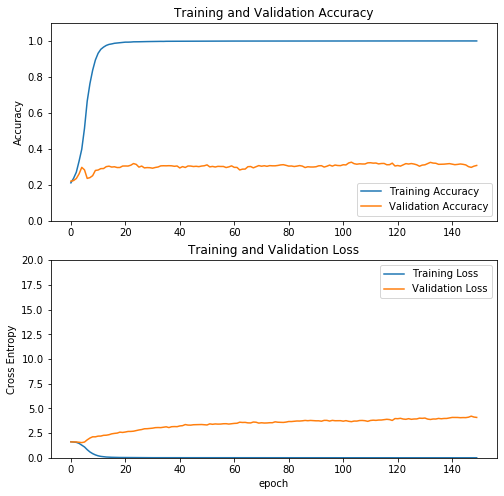

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 3028, num_label: 5, labels: 10, 100, 20, 200, 50.


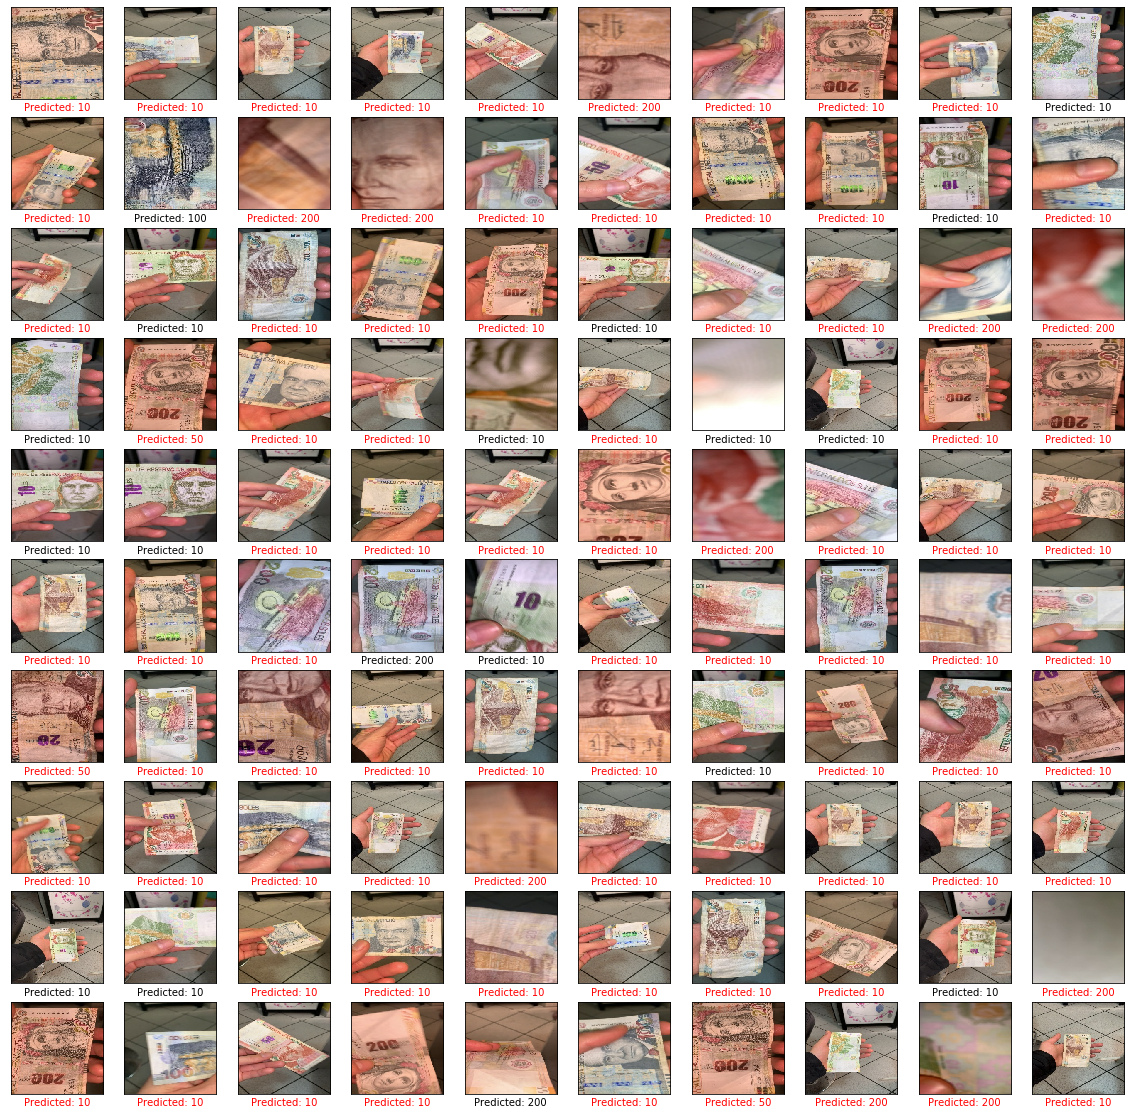

In [20]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    
    # predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    predict_label = classNames[id_predict]
    
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()